In [6]:
import pandas as pd
import os
import json
import sys
from os.path import expanduser
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pysd2cat.data import pipeline
from pysd2cat.analysis import correctness 

from data_converge.util import data_utils as du
from agavepy.agave import Agave, AgaveError

ag = Agave.restore()

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


DATA_CONVERGE_PROJECT="sd2e-project-43"

data_converge_base = os.path.join(expanduser("~"), 'sd2e-projects', DATA_CONVERGE_PROJECT)
experiment_dir = os.path.realpath(os.path.join(data_converge_base, 'test'))
experiment_dir_contents = [os.path.realpath(os.path.join(experiment_dir, x)) for x in os.listdir(experiment_dir)]

experiments = [x for x in  experiment_dir_contents 
               if os.path.isdir(x) and "dc_" in x]

DATA_CONVERGE_CORRECTNESS_DATA_PROJECT="sd2e-project-45"
data_converge_correctness_data_base = os.path.join(expanduser("~"), 'sd2e-projects', DATA_CONVERGE_CORRECTNESS_DATA_PROJECT)

correctness_dir = os.path.join(data_converge_correctness_data_base, 'correctness')
correctness_dir_contents = [os.path.realpath(os.path.join(correctness_dir, x)) for x in os.listdir(correctness_dir)]




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

def do_plot(res_meta, out_file="plot.png"):
    t=res_meta.groupby(['strain_name', 'inducer_concentration', 'timepoint']).agg(np.mean).reset_index()#.sort_values(by=["mean_correct_classifier"])
    #sns.distplot(t)
    plot_strains = [x for x in t.strain_name.unique() if "ducible" in x]
    t = t.loc[t.strain_name.str.contains("ducible")]

    
    #f, ax = plt.subplots()
    #ax.set_xscale("log")
    #ax.set_xlim(10e-6, 10e-4)
    #ax.set_ylim(0, 1)
    if 'timepoint' in t.columns:
        g = sns.FacetGrid(t, col="timepoint", hue="strain_name", height=10, margin_titles=True)
        g.map(sns.lineplot, 'inducer_concentration', "mean_correct_low_classifier")
        [plt.setp(ax.texts, text="") for ax in g.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')       
    else:
        g= sns.lineplot(dat.inducer_concentration, dat.mean_correct_low_classifier, ax=ax, label=strain)
        
    g.set(xscale="log")
    plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)    
    g.savefig(out_file)

    plt.close()

In [3]:
for experiment_analysis in correctness_dir_contents:

    data_converge_id = du.get_data_converge_id(experiment_analysis)
    csv_file = os.path.join(correctness_dir, data_converge_id + ".csv")
    if os.path.exists(csv_file):
        res = pd.read_csv(csv_file)
        data_converge_path = os.path.join(data_converge_base, 'test', data_converge_id)
        res_meta = du.get_meta(data_converge_path, 
                               du.get_record(data_converge_path)).merge(res, on="sample_id", how="inner")

        out_file_path = os.path.join(expanduser("~"), "tacc-work", "plots")
        if not os.path.exists(out_file_path):
            os.mkdir(out_file_path)
        out_file = os.path.join(out_file_path, data_converge_id + ".png")
        do_plot(res_meta, out_file)
        

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-CRISPR-Long-Duration-Time-Series-20191208_20200414085017.png


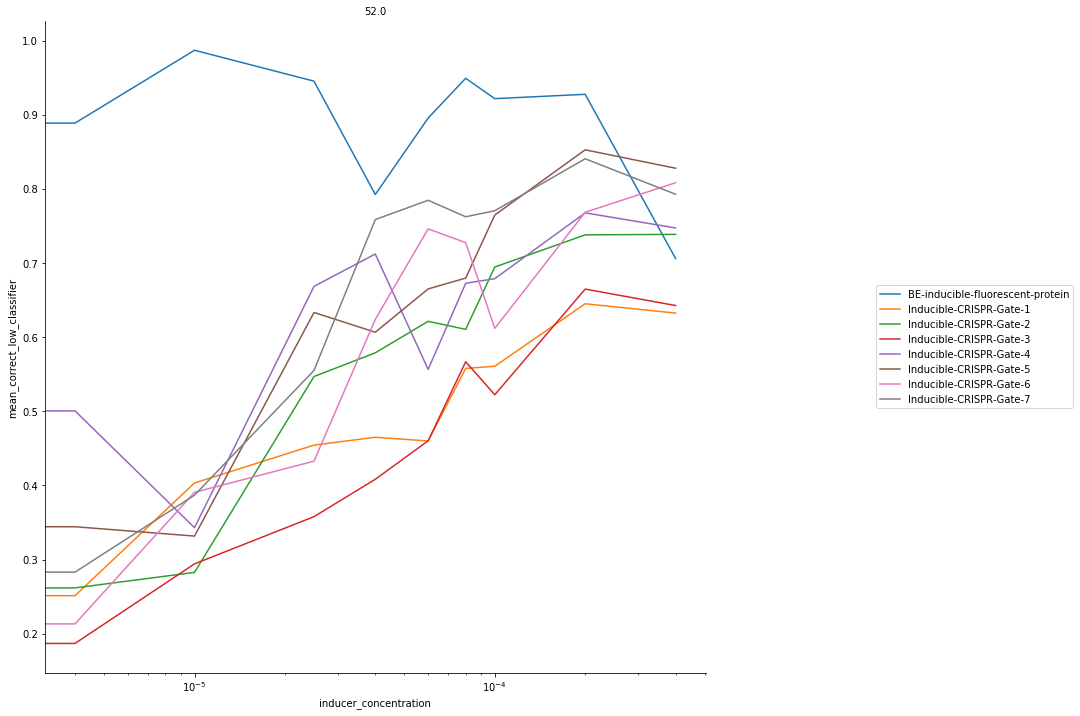

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-CRISPR-Dose-Response_20200327165322.png


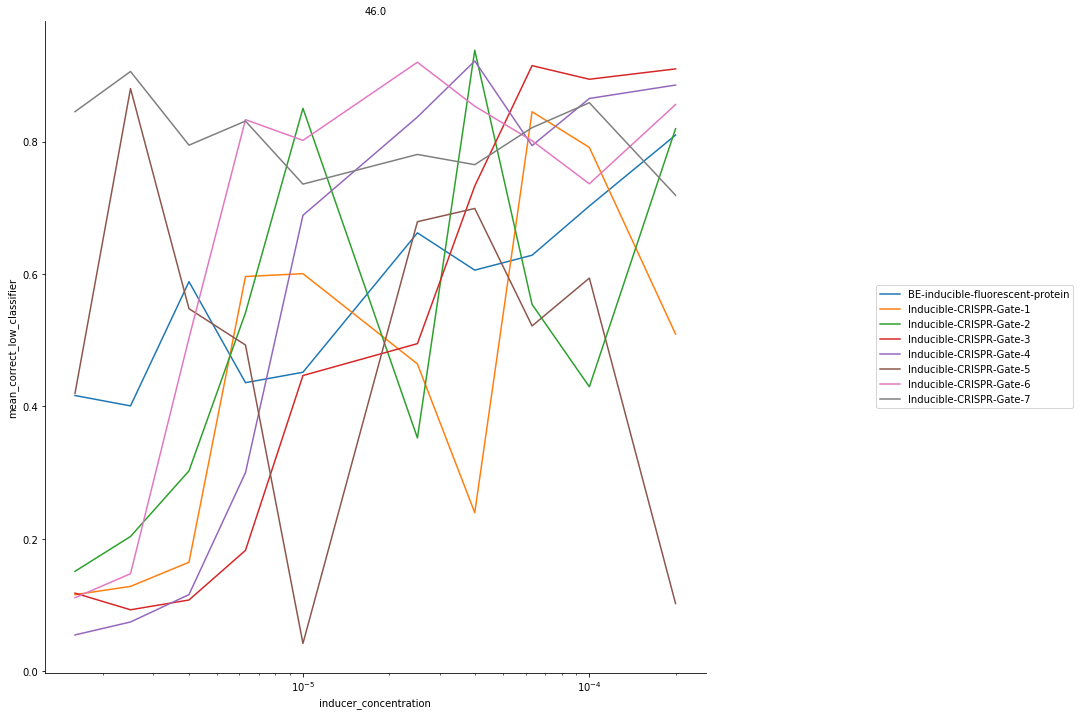

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-CRISPR-Long-Duration-Time-Series-20191208_20200328071458.png


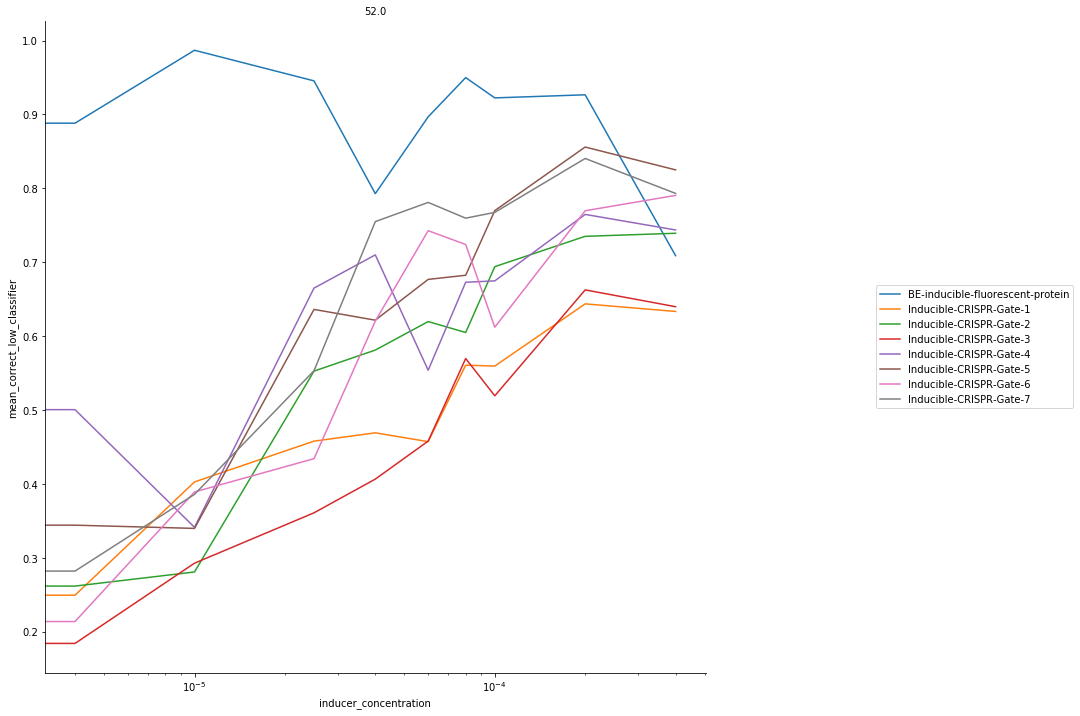

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200414095504.png


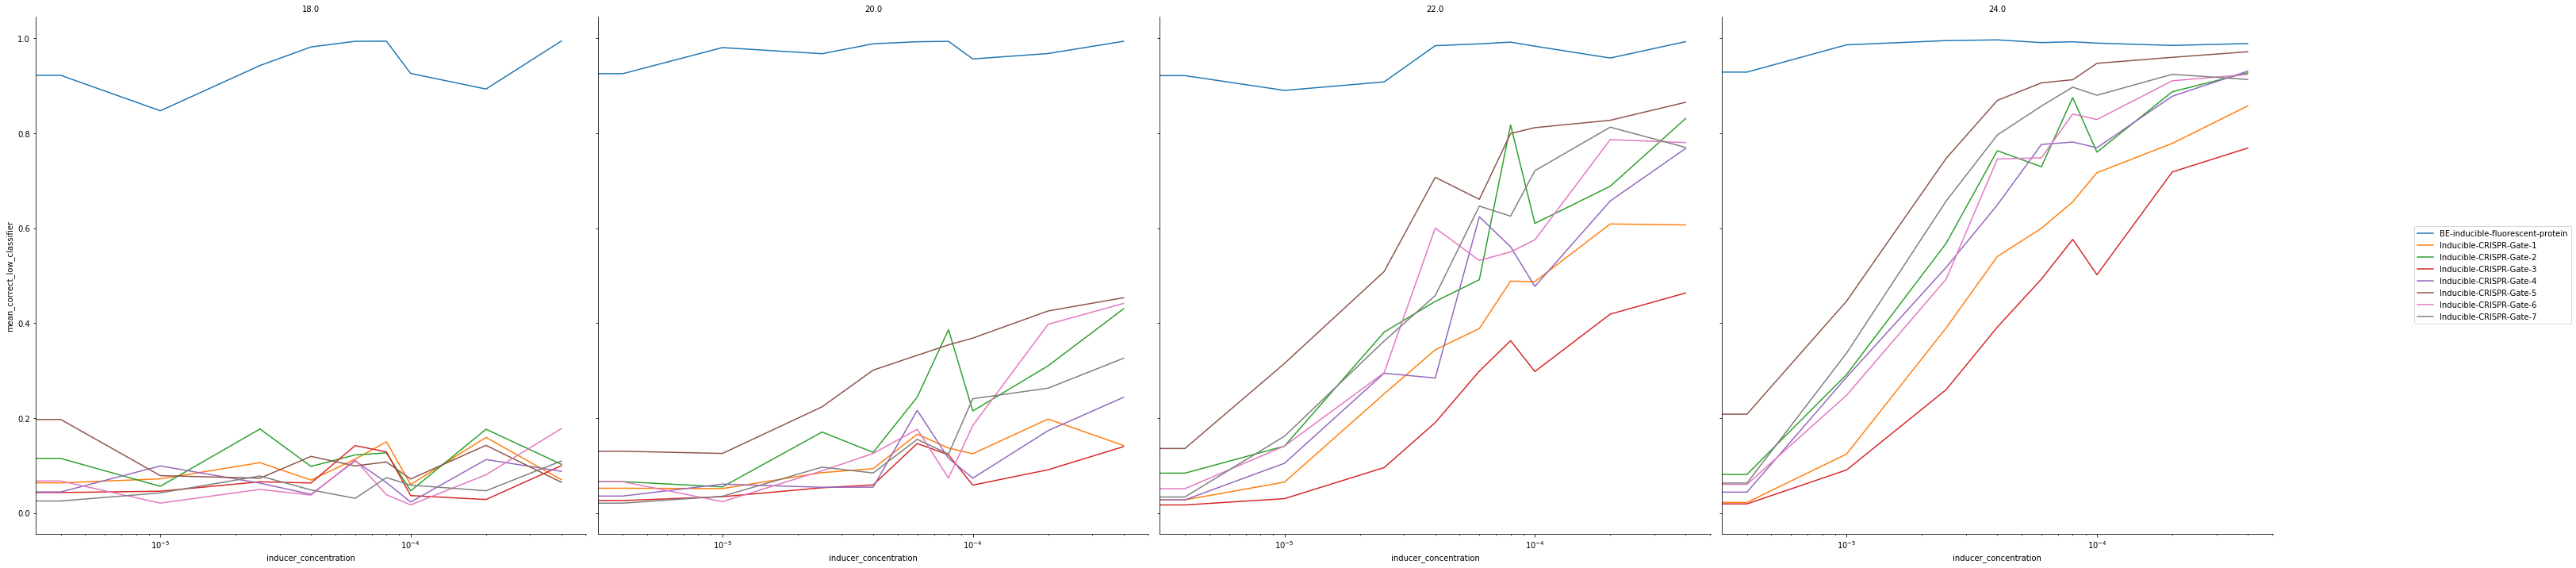

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200328030858.png


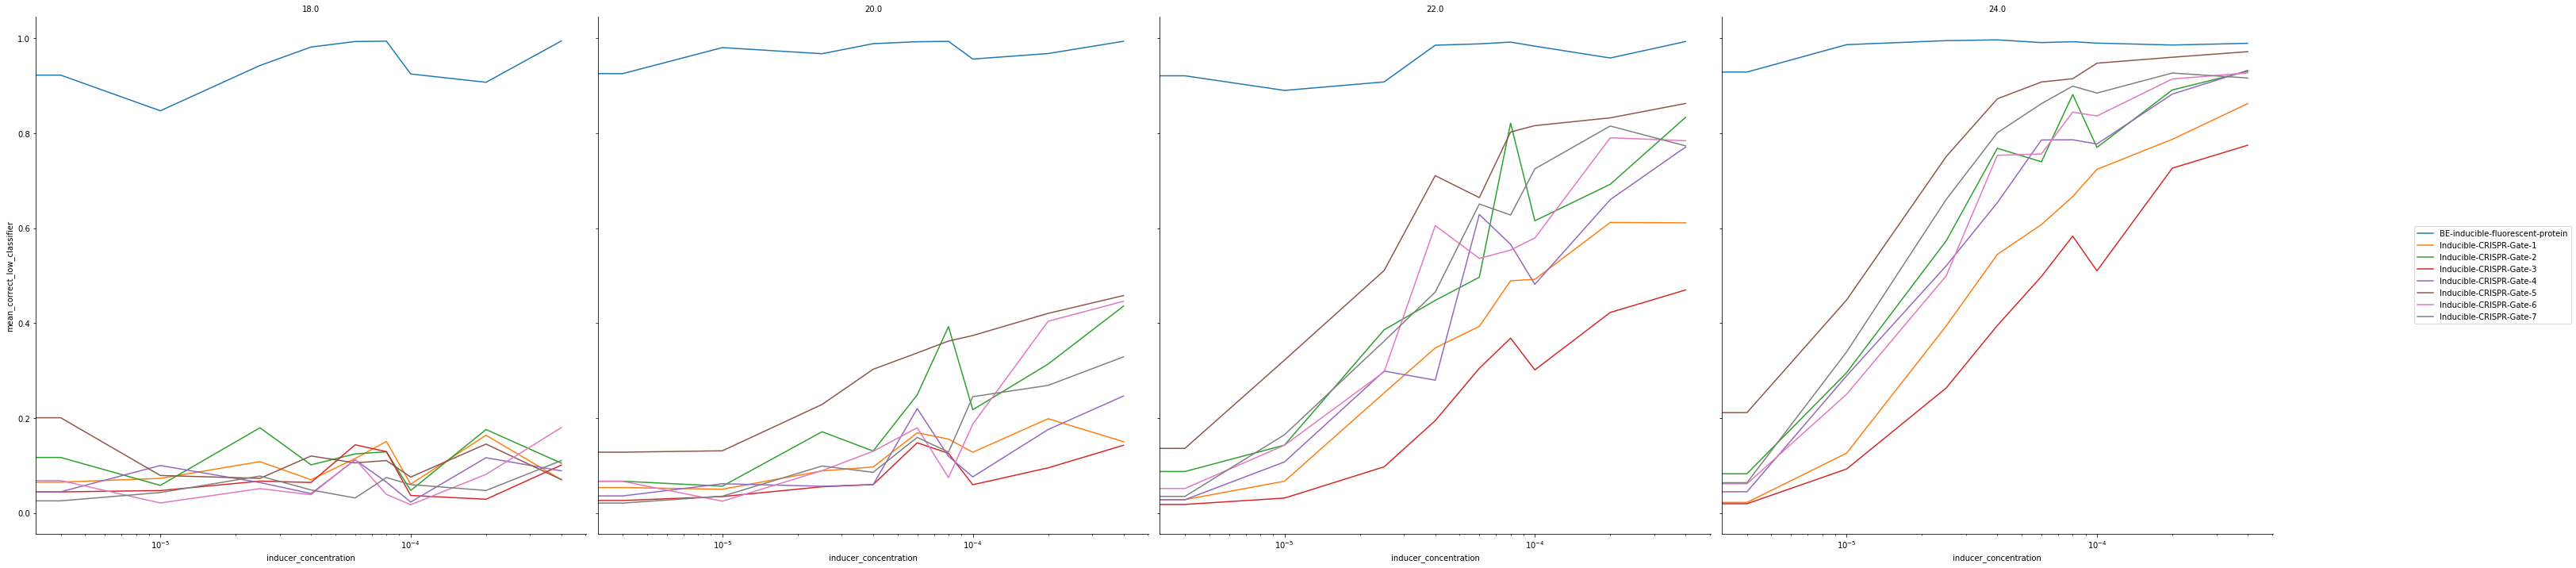

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-CRISPR-Dose-Response_20200414151033.png


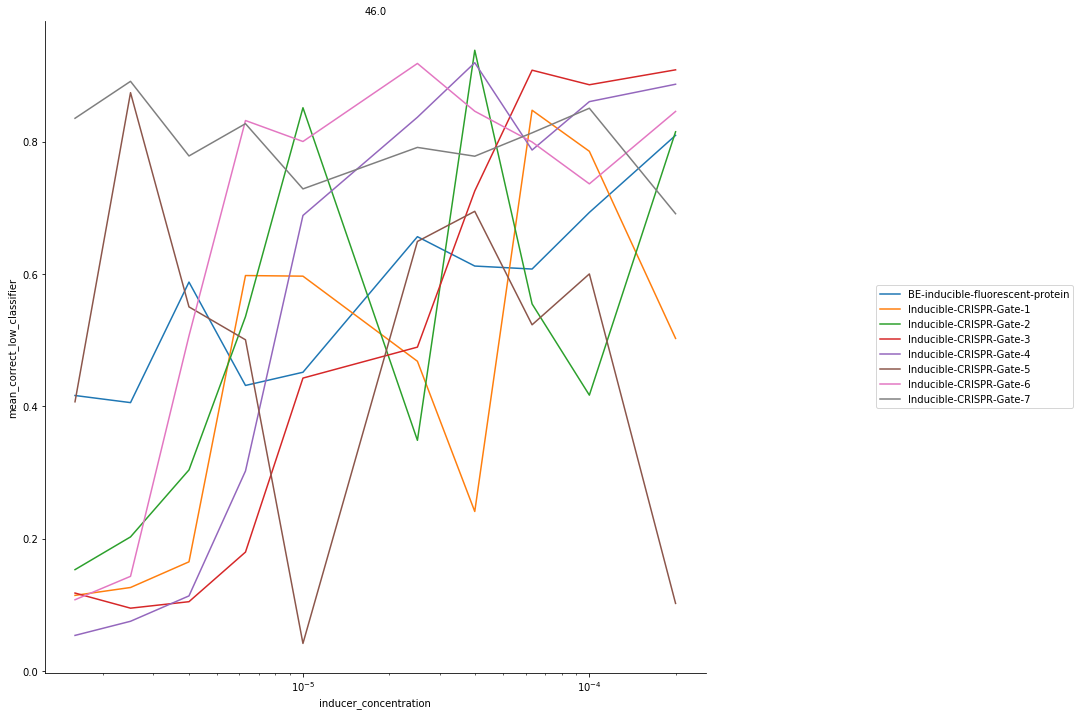

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200414152048.png


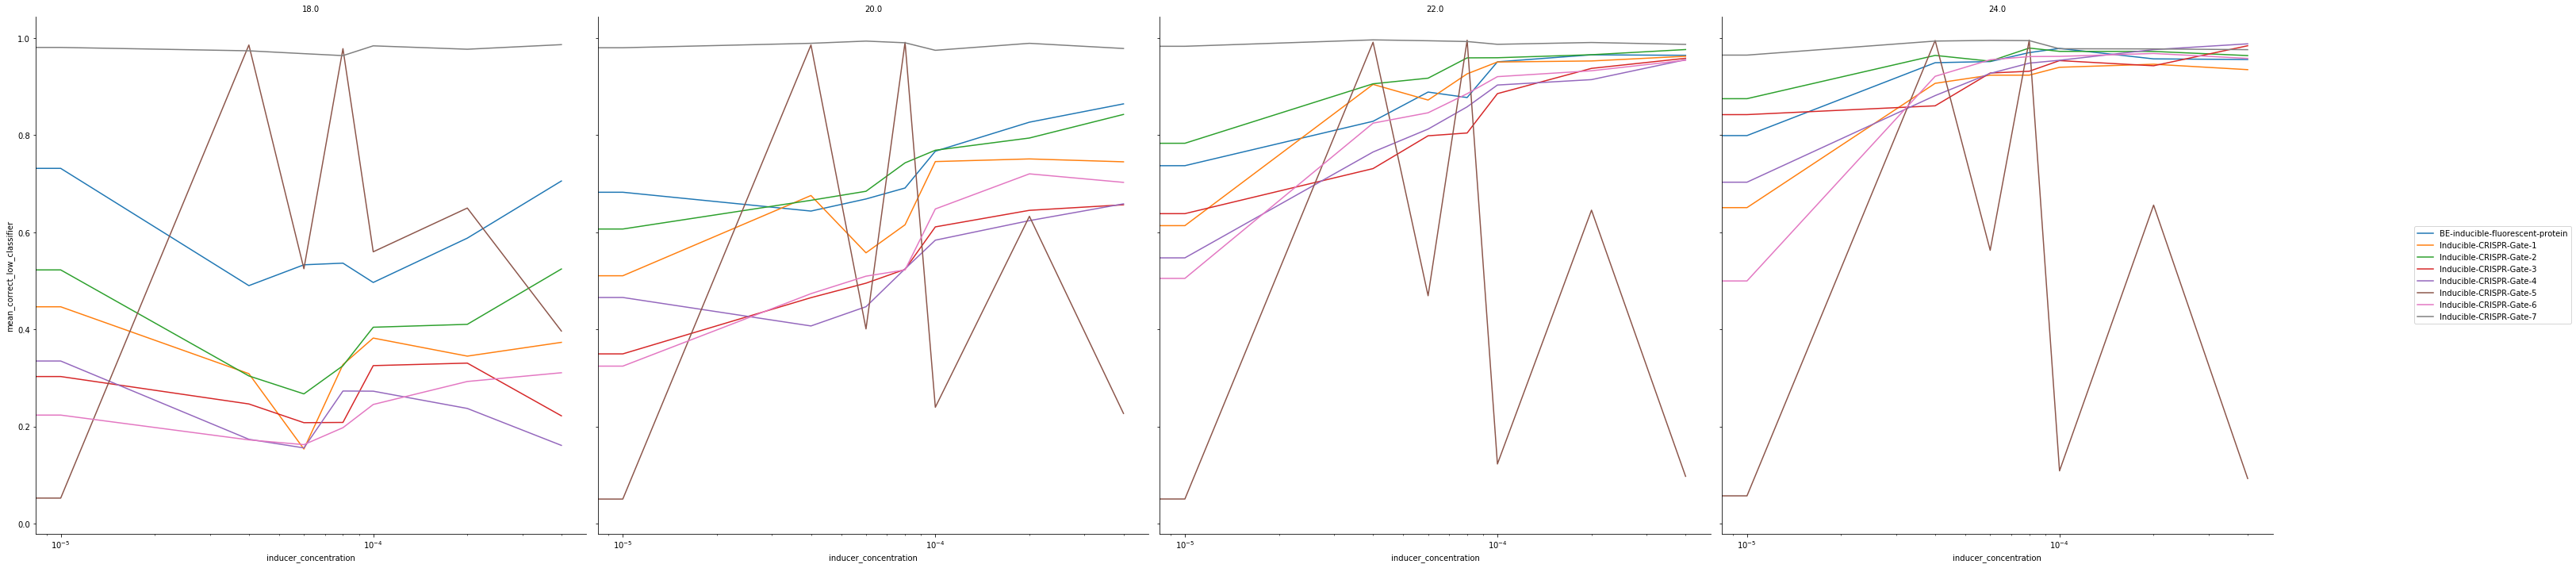

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-Beta-Estradiol-OR-Gate-Plant-TF-Dose-Response_20200414091814.png


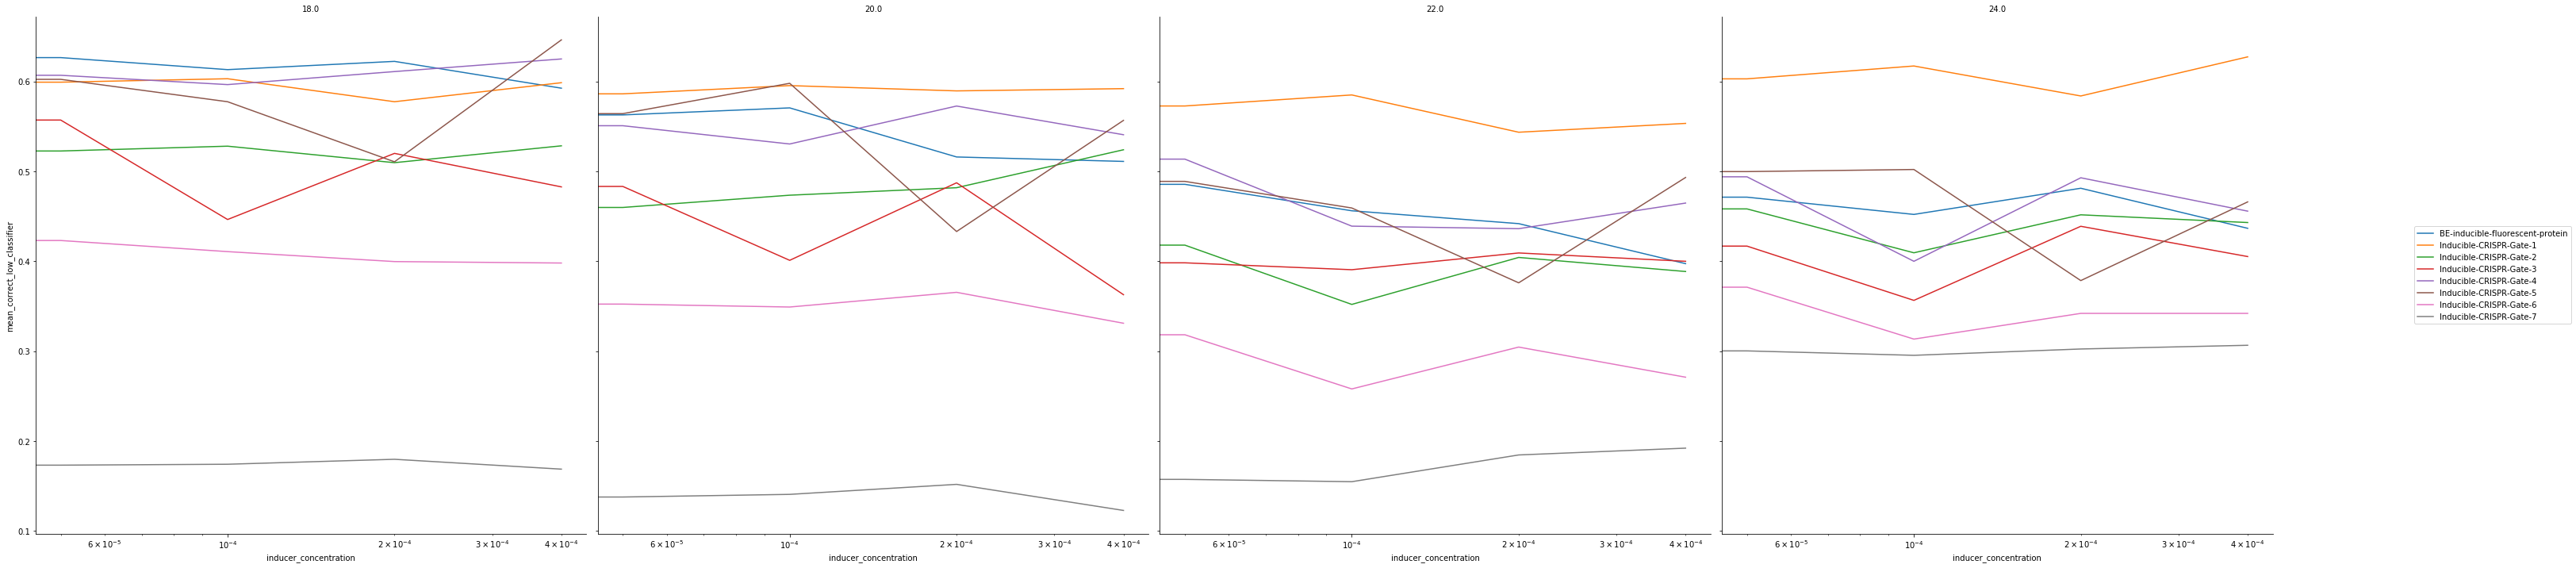

In [5]:
from IPython.display import display, Image
for experiment_analysis in correctness_dir_contents:
    data_converge_id = du.get_data_converge_id(experiment_analysis)
    out_file_path = os.path.join(expanduser("~"), "tacc-work", "plots")
    out_file = os.path.join(out_file_path, data_converge_id + ".png")
    print(out_file)
    display(Image('{}'.format(out_file)))
